In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception
inception.maybe_download()
model = inception.Inception()
resized_image = model.resized_image
y_pred = model.y_pred
y_logits = model.y_logits
with model.graph.as_default():
    # Add a placeholder variable for the target class-number.
    # This will be set to e.g. 300 for the 'bookcase' class.
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # Add a new loss-function. This is the cross-entropy.
    # See Tutorial #01 for an explanation of cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    # Get the gradient for the loss-function with regard to
    # the resized input image.
    gradient = tf.gradients(loss, resized_image)

Data has apparently already been downloaded and unpacked.


In [4]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    Find the noise that must be added to the given image so
    that it is classified as the target-class.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """

    # Create a feed-dict with the image.
    feed_dict = model._create_feed_dict(image_path=image_path)

    # Use TensorFlow to calculate the predicted class-scores
    # (aka. probabilities) as well as the resized image.
    pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

    # Convert to one-dimensional array.
    pred = np.squeeze(pred)

    # Predicted class-number.
    cls_source = np.argmax(pred)

    # Score for the predicted class (aka. probability or confidence).
    score_source_org = pred.max()

    # Names for the source and target classes.
    name_source = model.name_lookup.cls_to_name(cls_source,
                                                only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target,
                                                only_first_name=True)

    # Initialize the noise to zero.
    noise = 0

    # Perform a number of optimization iterations to find
    # the noise that causes mis-classification of the input image.
    for i in range(max_iterations):
        print("Iteration:", i)

        # The noisy image is just the sum of the input image and noise.
        noisy_image = image + noise

        # Ensure the pixel-values of the noisy image are between
        # 0 and 255 like a real image. If we allowed pixel-values
        # outside this range then maybe the mis-classification would
        # be due to this 'illegal' input breaking the Inception model.
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # Create a feed-dict. This feeds the noisy image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        # This also feeds the target class-number that we desire.
        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}

        # Calculate the predicted class-scores as well as the gradient.
        pred, grad = session.run([y_pred, gradient],
                                 feed_dict=feed_dict)

        # Convert the predicted class-scores to a one-dim array.
        pred = np.squeeze(pred)

        # The scores (probabilities) for the source and target classes.
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # noisy input image in order to move the predicted class
        # closer to the desired target-class.

        # Calculate the max of the absolute gradient values.
        # This is used to calculate the step-size.
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        step_size = 7 / grad_absmax

        # Print the score etc. for the source-class.
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # Print the score etc. for the target-class.
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # Print statistics for the gradient.
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()

        # If the score for the target-class is not high enough.
        if score_target < required_score:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            # Abort the optimization because the score is high enough.
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

In [5]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

In [6]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [7]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

Iteration: 0


Source score:  89.11%, class-number:  169, class-name: giant panda
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.002449, max:  0.002987, stepsize:   2343.67

Iteration: 1


Source score:  20.47%, class-number:  169, class-name: giant panda
Target score:   0.10%, class-number:  300, class-name: bookcase
Gradient min: -0.001525, max:  0.001076, stepsize:   4590.19

Iteration: 2


Source score:  75.97%, class-number:  169, class-name: giant panda
Target score:   0.07%, class-number:  300, class-name: bookcase
Gradient min: -0.002870, max:  0.002350, stepsize:   2439.19

Iteration: 3


Source score:  17.10%, class-number:  169, class-name: giant panda
Target score:   0.40%, class-number:  300, class-name: bookcase
Gradient min: -0.001479, max:  0.002278, stepsize:   3072.40

Iteration: 4


Source score:  27.13%, class-number:  169, class-name: giant panda
Target score:   1.11%, class-number:  300, class-name: bookcase
Gradient min: -0.001144, max:  0.001155, stepsize:   6060.04

Iteration: 5


Source score:   2.90%, class-number:  169, class-name: giant panda
Target score:   1.02%, class-number:  300, class-name: bookcase
Gradient min: -0.004342, max:  0.003307, stepsize:   1612.09

Iteration: 6


Source score:  56.36%, class-number:  169, class-name: giant panda
Target score:   2.23%, class-number:  300, class-name: bookcase
Gradient min: -0.003983, max:  0.004168, stepsize:   1679.51

Iteration: 7


Source score:   1.29%, class-number:  169, class-name: giant panda
Target score:   9.04%, class-number:  300, class-name: bookcase
Gradient min: -0.001260, max:  0.001810, stepsize:   3867.53

Iteration: 8


Source score:  14.32%, class-number:  169, class-name: giant panda
Target score:  12.70%, class-number:  300, class-name: bookcase
Gradient min: -0.002087, max:  0.002150, stepsize:   3255.90

Iteration: 9


Source score:   0.75%, class-number:  169, class-name: giant panda
Target score:  14.69%, class-number:  300, class-name: bookcase
Gradient min: -0.003420, max:  0.002495, stepsize:   2046.84

Iteration: 10


Source score:   1.11%, class-number:  169, class-name: giant panda
Target score:  29.31%, class-number:  300, class-name: bookcase
Gradient min: -0.002471, max:  0.002572, stepsize:   2721.17

Iteration: 11


Source score:  26.66%, class-number:  169, class-name: giant panda
Target score:  11.11%, class-number:  300, class-name: bookcase
Gradient min: -0.002080, max:  0.002280, stepsize:   3070.12

Iteration: 12


Source score:   0.14%, class-number:  169, class-name: giant panda
Target score:  18.28%, class-number:  300, class-name: bookcase
Gradient min: -0.001798, max:  0.001786, stepsize:   3893.53

Iteration: 13


Source score:   7.30%, class-number:  169, class-name: giant panda
Target score:  47.92%, class-number:  300, class-name: bookcase
Gradient min: -0.001604, max:  0.001427, stepsize:   4363.80

Iteration: 14


Source score:   0.01%, class-number:  169, class-name: giant panda
Target score:  83.08%, class-number:  300, class-name: bookcase
Gradient min: -0.000432, max:  0.000404, stepsize:  16216.18

Iteration: 15


Source score:   0.65%, class-number:  169, class-name: giant panda
Target score:  64.36%, class-number:  300, class-name: bookcase
Gradient min: -0.001042, max:  0.001137, stepsize:   6156.53

Iteration: 16


Source score:   0.03%, class-number:  169, class-name: giant panda
Target score:  91.60%, class-number:  300, class-name: bookcase
Gradient min: -0.000183, max:  0.000165, stepsize:  38195.80

Iteration: 17


Source score:   0.08%, class-number:  169, class-name: giant panda
Target score:  88.28%, class-number:  300, class-name: bookcase
Gradient min: -0.000715, max:  0.000362, stepsize:   9784.44

Iteration: 18


Source score:   0.06%, class-number:  169, class-name: giant panda
Target score:  92.80%, class-number:  300, class-name: bookcase
Gradient min: -0.000156, max:  0.000178, stepsize:  39368.35

Iteration: 19


Source score:   0.90%, class-number:  169, class-name: giant panda
Target score:  54.92%, class-number:  300, class-name: bookcase
Gradient min: -0.001607, max:  0.001708, stepsize:   4099.55

Iteration: 20


Source score:   0.67%, class-number:  169, class-name: giant panda
Target score:  76.08%, class-number:  300, class-name: bookcase
Gradient min: -0.000976, max:  0.000802, stepsize:   7174.47

Iteration: 21


Source score:   0.02%, class-number:  169, class-name: giant panda
Target score:  91.24%, class-number:  300, class-name: bookcase
Gradient min: -0.000180, max:  0.000210, stepsize:  33260.75

Iteration: 22


Source score:   6.31%, class-number:  169, class-name: giant panda
Target score:  75.71%, class-number:  300, class-name: bookcase
Gradient min: -0.001115, max:  0.001090, stepsize:   6276.21

Iteration: 23


Source score:   0.01%, class-number:  169, class-name: giant panda
Target score:  92.60%, class-number:  300, class-name: bookcase
Gradient min: -0.000235, max:  0.000255, stepsize:  27407.29

Iteration: 24


Source score:   0.15%, class-number:  169, class-name: giant panda
Target score:  91.96%, class-number:  300, class-name: bookcase
Gradient min: -0.000245, max:  0.000197, stepsize:  28621.38

Iteration: 25


Source score:   0.01%, class-number:  169, class-name: giant panda
Target score:  97.73%, class-number:  300, class-name: bookcase
Gradient min: -0.000052, max:  0.000071, stepsize:  98870.98

Iteration: 26


Source score:   0.00%, class-number:  169, class-name: giant panda
Target score:  98.40%, class-number:  300, class-name: bookcase
Gradient min: -0.000040, max:  0.000042, stepsize: 164883.28

Iteration: 27


Source score:   0.08%, class-number:  169, class-name: giant panda
Target score:  97.74%, class-number:  300, class-name: bookcase
Gradient min: -0.000054, max:  0.000059, stepsize: 118052.27

Iteration: 28


Source score:   0.00%, class-number:  169, class-name: giant panda
Target score:  98.96%, class-number:  300, class-name: bookcase
Gradient min: -0.000036, max:  0.000027, stepsize: 193678.56

Iteration: 29


Source score:   0.02%, class-number:  169, class-name: giant panda
Target score:  97.41%, class-number:  300, class-name: bookcase
Gradient min: -0.000084, max:  0.000069, stepsize:  83090.74

Iteration: 30


Source score:   0.00%, class-number:  169, class-name: giant panda
Target score:  99.65%, class-number:  300, class-name: bookcase
Gradient min: -0.000012, max:  0.000011, stepsize: 608461.29



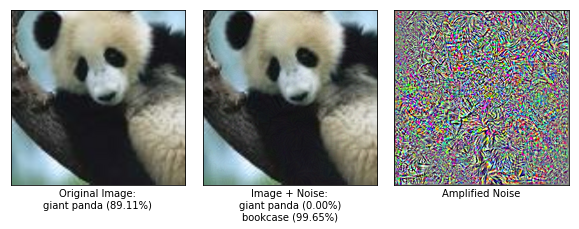

Noise min: -3.000, max: 3.000, mean: 0.003, std: 1.575


In [11]:
with tf.Session(graph=model.graph) as session:
    image_path = "inception/cropped_panda.jpg"

    adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)